# Forecasting Experiment on Solar Dataset

In [1]:
import os
import torch
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os

project_root_dir = "/data1/1shared/jinjiarui/run/Diffusion-TS"
os.chdir(project_root_dir)

from engine.solver import Trainer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from utils.io_utils import load_yaml_config, instantiate_from_config
from models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one

In [2]:
dataset = get_dataset("solar-energy", regenerate=True)
data_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test = [i for i in data_grouper(dataset.test)]
test = test[0]['target'].transpose(1,0)

train = [i for i in data_grouper(dataset.train)]
train = train[0]['target'].transpose(1,0)

data = np.concatenate([train, test], axis=0)
data = data[0:14016, 9:]
data = np.split(data, 73, 0)
data = np.array(data)

data.shape

(73, 192, 128)

In [3]:
train = data[0:65].reshape(-1, data.shape[-1])
test = data[65:]

scaler = MinMaxScaler()
train_scaled = normalize_to_neg_one_to_one(scaler.fit_transform(train))
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
test_scaled = normalize_to_neg_one_to_one(test_scaled)

In [4]:
class SolarDataset(Dataset):
    def __init__(self, data, regular=True, pred_length=72):
        super(SolarDataset, self).__init__()
        self.sample_num = data.shape[0]
        self.samples = data
        self.regular = regular
        self.mask = np.ones_like(data)
        self.mask[:, -pred_length:, :] = 0.
        self.mask = self.mask.astype(bool)

    def __getitem__(self, ind):
        x = self.samples[ind, :, :]
        if self.regular:
            return torch.from_numpy(x).float()
        mask = self.mask[ind, :, :]
        return torch.from_numpy(x).float(), torch.from_numpy(mask)

    def __len__(self):
        return self.sample_num

In [5]:
train_dataset = SolarDataset(train_scaled.reshape(65, -1, data.shape[-1]))
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True, pin_memory=True, sampler=None)

In [6]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './config/solar.yaml'
        self.save_dir = "./experiments/forecasting_exp"
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader':dataloader})

In [7]:
# trainer.train()

In [ ]:
_, seq_length, feat_num = test_scaled.shape
print(test_scaled.shape)

pred_length = 72

test_dataset = SolarDataset(test_scaled, regular=False, pred_length=pred_length)
real = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, feat_num))).reshape(test_scaled.shape)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_scaled.shape[0], shuffle=False, num_workers=0, pin_memory=True, sampler=None)

sample, *_ = trainer.restore(test_dataloader, shape=[seq_length, feat_num], coef=1e-2, stepsize=5e-2, sampling_steps=200)
sample = scaler.inverse_transform(unnormalize_to_zero_to_one(sample.reshape(-1, feat_num))).reshape(test_scaled.shape)
mask = test_dataset.mask
mse = mean_squared_error(sample[~mask], real[~mask])
print(mse)

(8, 192, 128)


conditional sampling loop time step:   0%|          | 1/500 [16:55<140:46:05, 1015.56s/it]

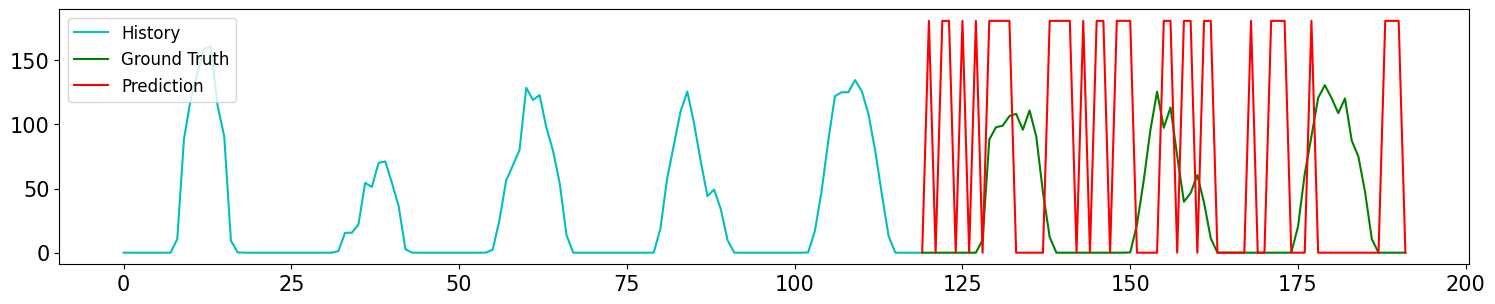

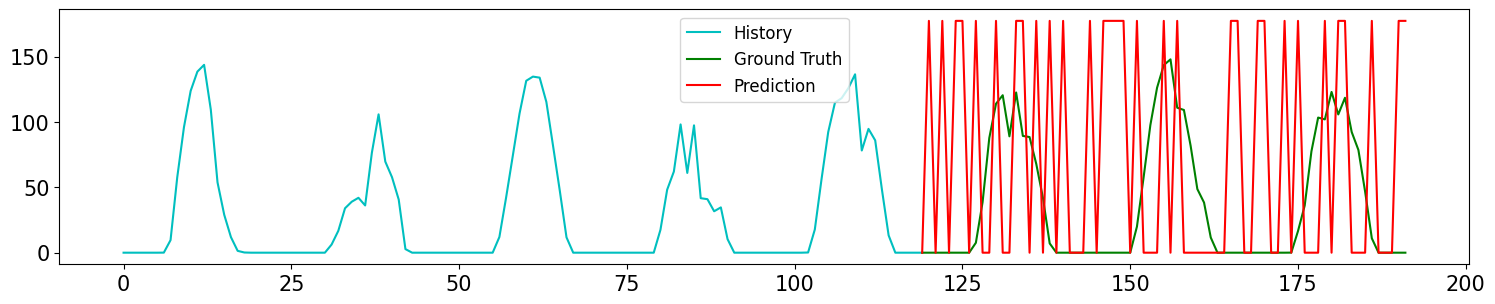

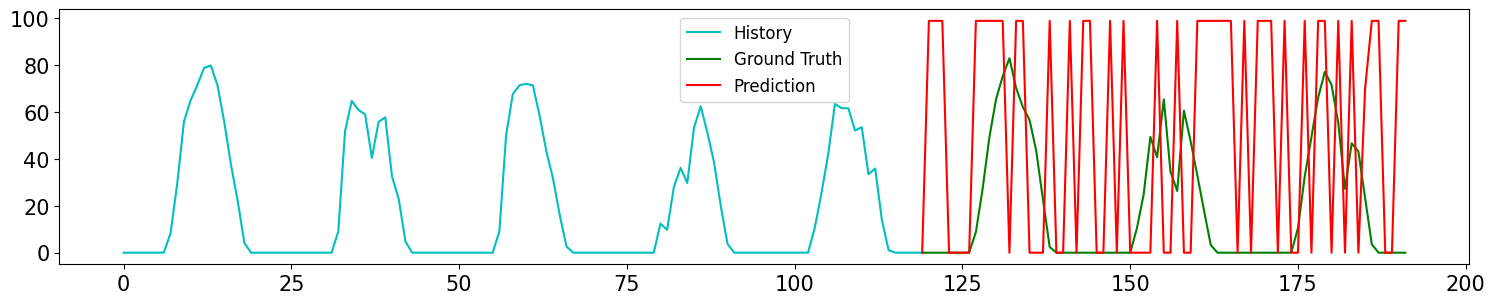

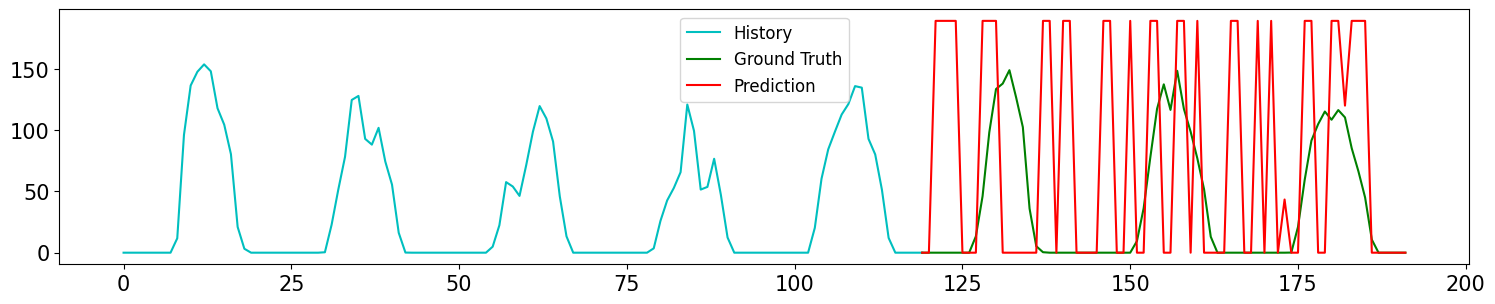

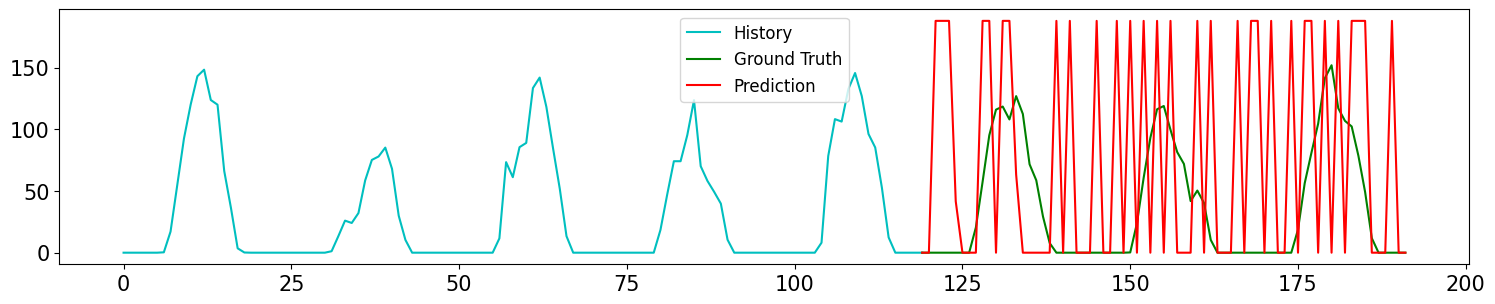

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12

for idx in range(5):
    plt.figure(figsize=(15, 3))
    plt.plot(range(0, seq_length-pred_length), real[0, :(seq_length-pred_length), idx], color='c', linestyle='solid', label='History')
    plt.plot(range(seq_length-pred_length-1, seq_length), real[0, -pred_length-1:, idx], color='g', linestyle='solid', label='Ground Truth')
    plt.plot(range(seq_length-pred_length-1, seq_length), sample[0, -pred_length-1:, idx], color='r', linestyle='solid', label='Prediction')
    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    plt.show()